**Contexto**

Iremos trabalhar com uma base de dados de passageiros aéreos, nosso objetivo é **prever o número de passageiros aéreos no futuro**.

Temos um dataset com número de passageiros variando no decorrer do tempo, temos então um exemplo de **série temporal**.

In [316]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import numpy as np

# Configrando o tamanho de todos os gráficos que serão gerados no notebook de forma global
# A mesma coisa da forma manual seria: plt.figure(figsize=(12,5))
mpl.rcParams['figure.figsize'] = (12,6)

# Configurando a fonte de forma global
mpl.rcParams['font.size'] = 16

SEED = 42

In [317]:
df = pd.read_csv('passageiros.csv')
df.head()

,tempo,passageiros
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


**Tipos dos dados**:
- **Tempo**: Números de ponto flutuante (float64)
- **Passageiros**: Números inteiros (int64)

Não há dados nulos.

In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tempo        144 non-null    float64
 1   passageiros  144 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.4 KB


**Visualização dos passageiros ao decorrer do tempo**

<Axes: xlabel='tempo', ylabel='passageiros'>

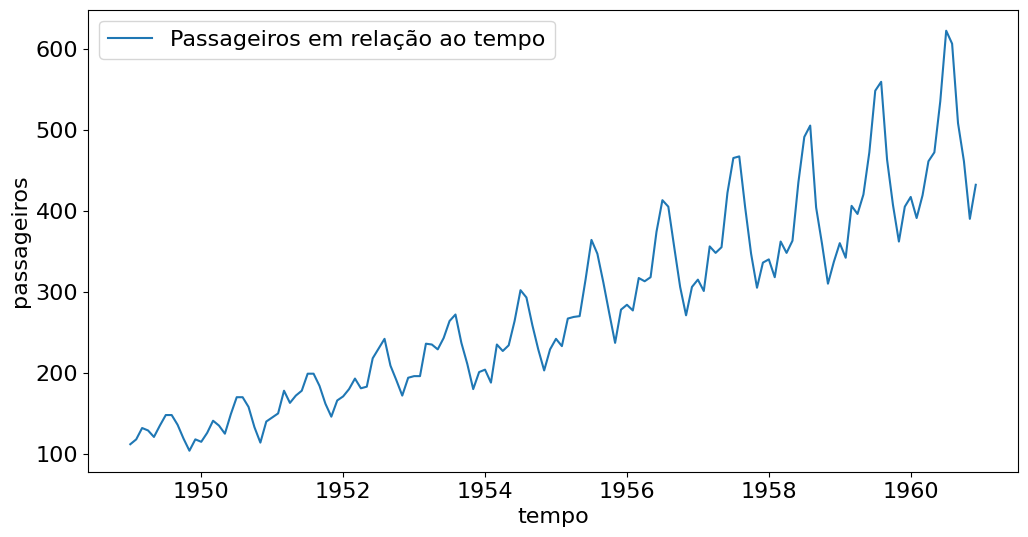

In [319]:
sns.lineplot(x='tempo', y='passageiros', data=df, label='Passageiros em relação ao tempo')

### Pré-processamento

Antes de realizar a previsão, iremos padronizar os dados para deixá-los na mesma escala com o objetivo de facilitar o aprendizado de máquina, para a rede neural conseguir aprender a relação entre entrada e saída.

**Lembrando**: A padronização (StandardScaler) não é sensível a outliers, portanto, caso houver outliers no dataset, serão desconsiderados.

**OBS**:
- **:** antes da vírgula refere-se a todas as linhas
- **0** ou **1** após a vírgula especifica a coluna que está sendo acessada.

In [320]:
sc = StandardScaler()
data_scaled = sc.fit_transform(df)
df_scaled = pd.DataFrame({
    'tempo': data_scaled[:,0], # Seleciona todas as linhas da 1° coluna do array
    'passageiros': data_scaled[:,1] # Seleciona todas as linhas da 2° coluna do array
})

# Dados padronizados
df_scaled.head()

,tempo,passageiros
0,-1.720064,-1.407779
1,-1.696007,-1.357590
2,-1.671950,-1.240483
3,-1.647894,-1.265578
4,-1.623837,-1.332496


In [321]:
# Separando caractéristicas dos rótulos
X = df_scaled['tempo']
y = df_scaled['passageiros']

In [322]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fazendo a separação entre treino e teste manualmente para simular a mesma situação do prof
quantity_train = int(len(X) * 0.80) # 80% para o treino e 20% para o teste
X_train = X[0:quantity_train].values
y_train = y[0:quantity_train].values

X_test = X[quantity_train:len(X)].values
y_test = y[quantity_train:len(X)].values

### Construindo um modelo simples

Iremos criar uma rede neural com uma **sequência densa** de camadas, ou seja, cada neurônio estará conectado com todos os neurônios da camada seguinte, e assim por diante.

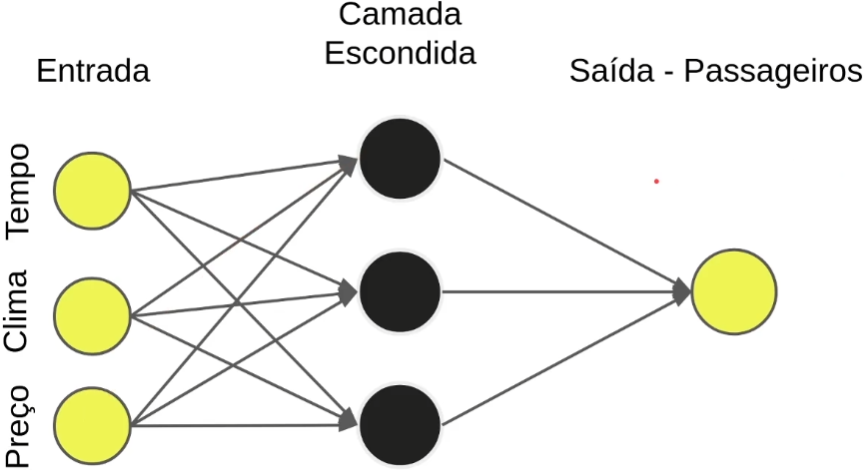

A nossa primeira entrada será apenas o tempo, portanto, teremos uma camada densa com apenas 1 neurônio.

z = W (peso) * x (entrada) + b (víes)

Uma função de **ativação linear** pode multiplicar o z (resultado de passageiros, por exemplo) por uma constante, no Keras para uma ativação linear o padrão é multiplicar por 1, ou seja, não irá interferir no resultado.

In [323]:
model = keras.Sequential()

# Adicionando a camada de entrada

# O primeiro parâmetro significa a quantidade de neurônios da camada seguinte
# O parametro input_dim é o tamanho da entrada
model.add(keras.layers.Dense(1, # 1 neurônio na camada 0
                             input_dim=1, # Define as dimensões da entrada, no caso apenas uma dimensão
                             kernel_initializer='Ones', # Inicializando o kernel (pesos da rede neural) com o número 1
                             activation='linear', # Função de ativação linear
                             use_bias=False)) # Não iremos otimizar o bias (viés) para o nosso caso, pois não irá fazer diferença por enquanto

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


A função MSE (Mean Squared Error ou Erro Médio Quadrático) serve para medir a diferença entre o valor previsto (estimativa) e o valor real.

In [324]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.R2Score()])

In [325]:
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 1)              │             1 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1 (4.00 B)

 Trainable params: 1 (4.00 B)

 Non-trainable params: 0 (0.00 B)

In [326]:
model.fit(X_train, y_train)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0962 - r2_score: 0.8102  


In [327]:
# Prevendo os dados de treino apenas para gerar uma reta
y_predicts_train = model.predict(X_train)

# Prevendo os dados de teste
y_predicts_test = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


**Mudando a escala para visualização**

In [328]:
# Função para realizar a transformação inversa de forma mais dinâmica
def inverse_transform(train_predicts, test_predicts):
    # Treino
    df_train = pd.DataFrame({
        'tempo': X_train,
        'passageiros': train_predicts[:,0]
    })

    # Realizando a transformação inversa para os dados de TREINO
    df_train = sc.inverse_transform(df_train)

    df_train = pd.DataFrame(df_train)
    df_train.columns = ['tempo', 'passageiros']

    # Teste
    df_test = pd.DataFrame({
        'tempo': X_test,
        'passageiros': test_predicts[:,0]
    })

    # Realizando a transformação inversa para os dados de TESTE
    df_test = sc.inverse_transform(df_test)

    df_test = pd.DataFrame(df_test)
    df_test.columns = ['tempo', 'passageiros']

    return df_train, df_test

<Axes: xlabel='tempo', ylabel='passageiros'>

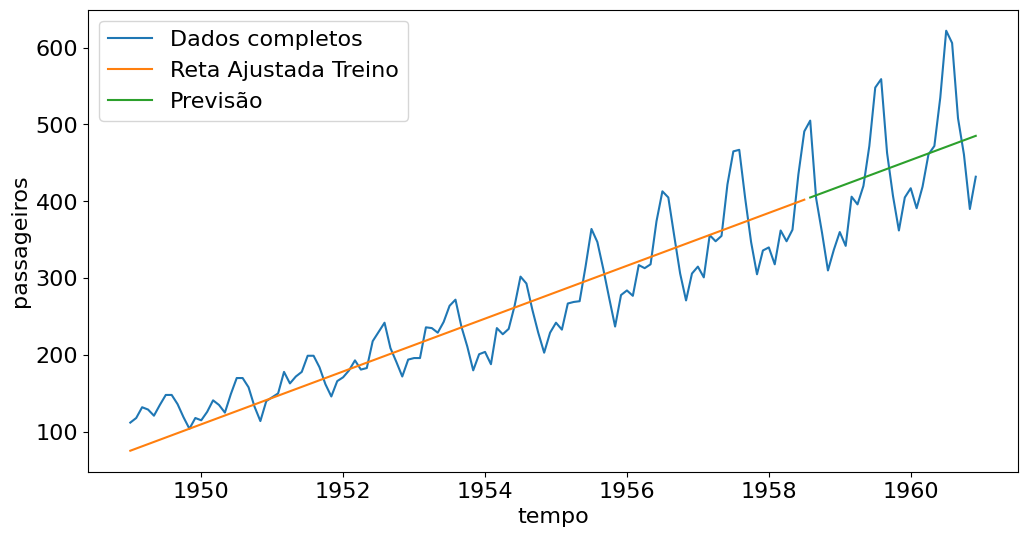

In [329]:
df_predicts_train, df_predicts_test = inverse_transform(y_predicts_train, y_predicts_test)

sns.lineplot(x='tempo', y='passageiros', data=df, label='Dados completos')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_train, label='Reta Ajustada Treino')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_test, label='Previsão')

### Construindo um modelo com mais de uma camada

Camada de entrada

In [330]:
model_2 = keras.Sequential()

model_2.add(keras.layers.Dense(8, # 8 neurônios para a camada oculta
                               input_dim=1, # Uma dimensão para entrada
                               kernel_initializer='random_uniform', # Inicialização de valores aleatórios para os pesos
                               activation='linear', # Mantendo a função de ativação linear
                               use_bias=False))

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Camada oculta

In [331]:
model_2.add(keras.layers.Dense(8, 
                               kernel_initializer='random_uniform', 
                               activation='linear',
                               use_bias=False))

Camada de saída

Iremos adicionar a função **sigmoid**, normalmente utilizada em **camadas de saída** para redes neurais de **regressão linear**.

In [332]:
model_2.add(keras.layers.Dense(1, # Apenas 1 neurônio pois a saída será numérica
                               kernel_initializer='random_uniform', 
                               activation='linear',
                               use_bias=False))

Compilando o modelo com os mesmos parâmetros anteriores

In [333]:
model_2.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.R2Score()])

In [334]:
model_2.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 8)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 80 (320.00 B)

 Non-trainable params: 0 (0.00 B)

Treinando o modelo

In [335]:
model_2.fit(X_train, y_train,
            epochs=50)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7086 - r2_score: -0.2155  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6934 - r2_score: -0.1730 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7125 - r2_score: -0.2117 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6808 - r2_score: -0.2829 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7609 - r2_score: -0.2032 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6779 - r2_score: -0.1135 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6938 - r2_score: -0.3967 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6542 - r2_score: -0.1893 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6609 - r2_score: -0.2290 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6526 - r2_score: -0.2270
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7100 - r2_score: -0.1389 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6925 - r2_scor

Realizando a mesma predição e transformação inversa anteriormente

In [336]:
# Prevendo os dados de treino apenas para gerar uma reta
y_predicts_train = model_2.predict(X_train)

# Prevendo os dados de teste
y_predicts_test = model_2.predict(X_test)

df_predicts_train, df_predicts_test = inverse_transform(y_predicts_train, y_predicts_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


**Observações:**

Como é possível perceber, não houve diferença alguma em relação ao modelo anterior com apenas uma camada, então precisamos pensar de uma forma diferente.

<Axes: xlabel='tempo', ylabel='passageiros'>

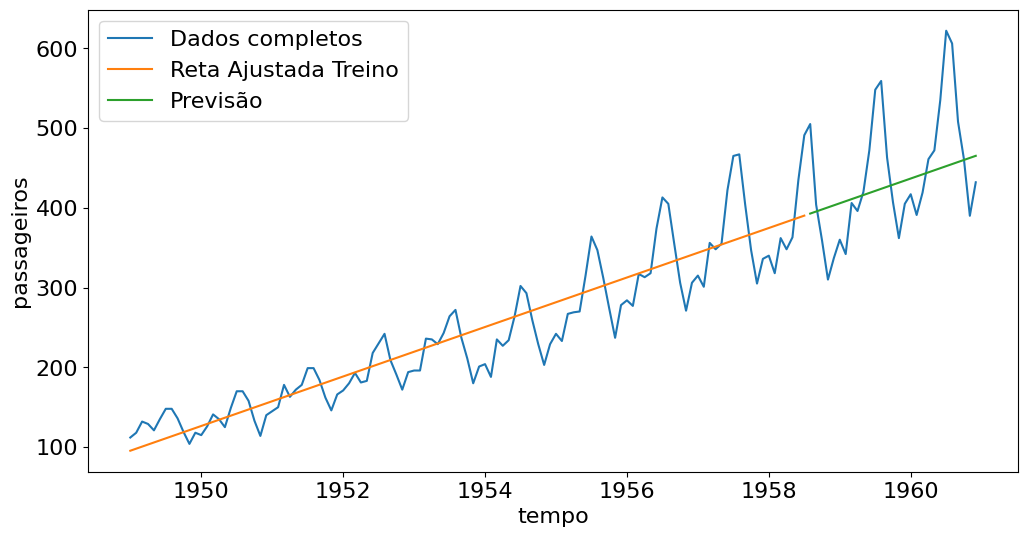

In [337]:
sns.lineplot(x='tempo', y='passageiros', data=df, label='Dados completos')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_train, label='Reta Ajustada Treino')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_test, label='Previsão')

### Preparação de dados de séries temporais

Uma série temporal é uma sequência de dados observados ao longo do tempo, que é exatamente com o que estamos mexendo.

Em uma série temporal, o objetivo é usar valores passados para prever valores futuros, por exemplo, queremos prever o número de passageiros no Dia 7 usando os valores dos dias 1 a 6.

Dia    | Passageiros
-------|------------
1      | 100
2      | 120
3      | 150
4      | 170
5      | 200
6      | 230

Porém, para realizar isso, apenas com 1 valor de entrada, não é possível que o modelo aprenda as **oscilações sazonais** que normalmente ocorrem em uma série temporal. Para isto, é necessário pares de valores, que iremos visualizar a seguir.

**Dividindo a Série Temporal em Janelas (Sliding Window)**

Para que um modelo entenda os padrões temporais, precisamos criar **janelas de dados** (também chamadas de **lags** ou **passos**) que conectem valores passados (**X**) ao próximo valor (**y**).

Por exemplo:

Com uma janela de 3 passos, podemos transformar a série da seguinte forma:


Entrada (X)	    | Saída (y)
----------------|-----------------
[100, 120, 150]	| 170
[120, 150, 170]	| 200
[150, 170, 200]	| 230

Cada **X** é uma sequência de 3 valores consecutivos (janelas deslizantes)
Cada **y** é o valor seguinte ao último valor em **X**.

**Por que fazer isso?**

Os modelos de Machine Learning ou Redes Neurais não conseguem interpretar os dados temporais diretamente, porque eles tratam cada exemplo de forma independente. Porém, com as janelas:

- Adicionamos **dependência temporal** (ou seja, conectamos valores passados ao futuro).
- Criamos um conjunto de dados estruturado com **entradas (X)** e **saídas (y)**, que pode ser usado em algoritmos comuns.

**Métodos de criação de Janelas**

Existem várias formas de criar essas janelas deslizantes:
- De forma manual com loop.
- Com bibliotecas como numpy ou com o próprio Keras
    - **sliding_window_view (Numpy)**: Cria todas as janelas em uma única operação vetorizada.
    - **TimeSeriesGenerator (Keras)**: Gera janelas automaticamente, ideal para Deep Learning

In [338]:
# Criando uma função para realizar a preparação de séries temporais de forma manual
def window_view(array, n_length):
    X, y = [], []

    # O loop começara com n_length
    for i in range(n_length, len(array)):

        # Faz uma subtração com a iteração atual e a quantidade de passos
        X.append(list(array[i-n_length:i])) # Janela de entrada
        y.append(array[i]) # Valor de saída 

    return np.array(X), np.array(y)

In [339]:
# Realizando a preparação dos dados em 3 passos, ou seja, se baseará em 3 linhas anteriores para prever a 4° linha
X_train_time_series, y_train_time_series = window_view(y_train, 1)

X_test_time_series, y_test_time_series = window_view(y_test, 1)

# Os dois arrays precisam ter o mesmo comprimento
print(f'Comprimento X: {len(X_train_time_series)}')
print(f'Comprimento y: {len(y_train_time_series)}')

Comprimento X: 114
Comprimento y: 114


In [340]:
model_time_series = keras.Sequential()

# Camada de entrada
model_time_series.add(keras.layers.Dense(8, input_dim=1, # Devemos alterar a dimensão dos dados de entrada dependendo da quantidade de passos
                                         kernel_initializer='ones',
                                         activation='linear',
                                         use_bias=False))

# Camada oculta
model_time_series.add(keras.layers.Dense(64,
                               kernel_initializer='random_uniform', 
                               activation='sigmoid',
                               use_bias=False))

# Camada de saída
model_time_series.add(keras.layers.Dense(1, # Apenas 1 neurônio pois a saída será numérica
                               kernel_initializer='random_uniform', 
                               activation='linear',
                               use_bias=False))

c:\Users\DIOGO-PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [341]:
# Compilando o modelo
model_time_series.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.R2Score()])

In [342]:
model_time_series.fit(X_train_time_series, y_train_time_series,
                      epochs=50)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7374 - r2_score: -0.2243  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6363 - r2_score: -0.1472 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5174 - r2_score: 0.0208 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5408 - r2_score: 0.0702 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5852 - r2_score: 0.0938 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4916 - r2_score: 0.1157 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4499 - r2_score: 0.1371 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4513 - r2_score: 0.1613 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4890 - r2_score: 0.1880 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4273 - r2_score: 0.2179 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4085 - r2_score: 0.2514 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3961 - r2_score: 0.294

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Axes: xlabel='tempo', ylabel='passageiros'>

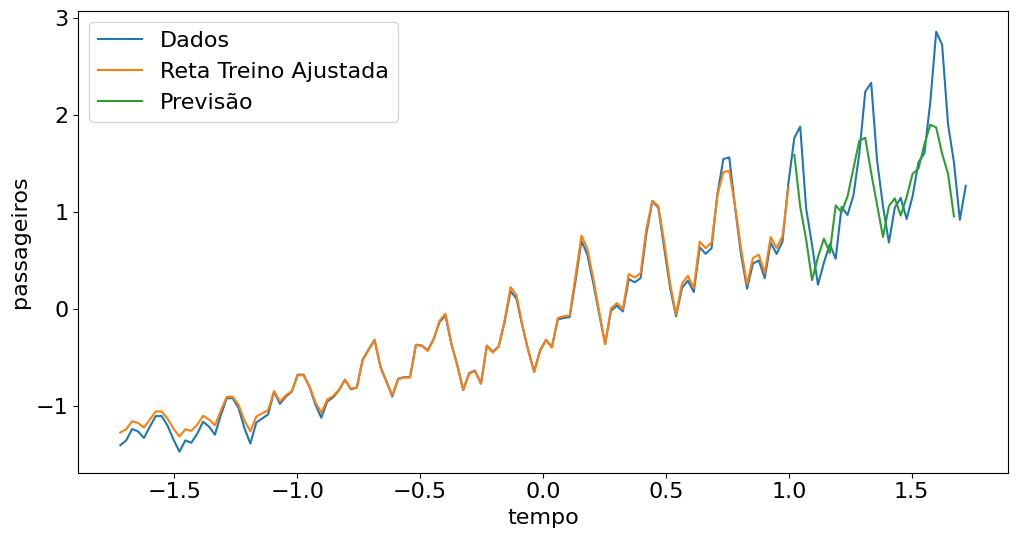

In [343]:
y_predicts_train = model_time_series.predict(X_train_time_series)
y_predicts_test = model_time_series.predict(X_test_time_series)


df_predicts_train = pd.DataFrame({
    'tempo': df_scaled['tempo'][0:len(y_predicts_train)], # de 0 até o número total de itens previstos no treino
    'passageiros': y_predicts_train.flatten() # É necessário fazer o flatten pois y_predicts_train é um array bi-dimensional, o dataframe do pandas precisa de um array unidimensional
})

df_predicts_test = pd.DataFrame({
    'tempo': df_scaled['tempo'][len(y_predicts_train):len(y_predicts_train) + len(y_predicts_test)], # do número total de itens previstos no treino + o total previstos no teste
    'passageiros': y_predicts_test.flatten()
})

sns.lineplot(x='tempo', y='passageiros', data=df_scaled, label='Dados')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_train, label='Reta Treino Ajustada')
sns.lineplot(x='tempo', y='passageiros', data=df_predicts_test, label='Previsão')